<a href="https://colab.research.google.com/github/ahmadbasyouni10/NYU-AI-School-Labs/blob/main/Lab_2_Classification_(advanced%3B_student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

In [ ]:
! pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


**NOTE**: Please make a personal copy of this notebook by selecting 'File' > 'Save a copy in Drive' in the menu bars above.

# Classification

Like regression, classification is a fundamental and general type of machine of machine learning problem. Classification involves assigning an input to a **class**. Like regression problems, classification problems are ubiquitous in the real world:
* CAPTCHAs: inputs are images and classes are whether or not there is a bus/truck/etc.
* Predicting if an email or phone number is spam or not.
* Determining the genre of a movie or book.

More formally, classification problems are described as learning a function $f$ that assigns an input $x$ to one of $K$ classes $c \in C$, where $C$ is the set of all classes. We generally represent the classes as integers (e.g. 0, 1, 2, etc.), where the value and order of the integers doesn't reflect any structure in the classes.

## Setting and Data

For this lab, we'll use consider an artificial task of distinguishing whether a point belongs to one of two classes. The points will be two dimensional (i.e. $\in \mathbb{R}^2$) and for convenience we'll call the classes 0 and 1.

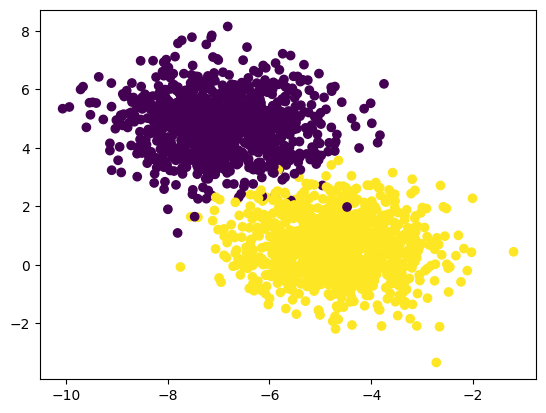

In [ ]:
from sklearn.datasets import make_blobs
# Follow these instructions to set up matplotlib widget for Jupyter Lab
# https://github.com/matplotlib/jupyter-matplotlib#installation
%matplotlib widget
%matplotlib inline

import numpy
import matplotlib.pyplot as plot
from tqdm import tqdm

# random_seed = numpy.random.randint(0,100)
random_seed = 12

X, y = make_blobs(n_samples=2000, centers=2, n_features=2,
                  random_state=random_seed)

#convert to pytorch tensors
X = torch.tensor(X).float()
y = torch.tensor(y).float()

plot.figure()
plot.scatter(X[:,0], X[:,1], c=y)
plot.show()

In [ ]:
print(X.shape)

# split into train and test
n_exs = len(X)
n_train = int(n_exs * .8)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

torch.Size([2000, 2])


## Model

To model this problem, we'll use a model that estimates the **probability** that a given input belongs to each of the $K$ classes (e.g. estimating $p(y_i = 1|x_i)$).
Because probabilities must be in $[0, 1]$, the model's outputs must be in that range as well.
To do this, we'll use a popular classification model called logistic regression (which, despite the name is a classification model).
This model gets its name from the logistic function $\sigma$, which looks like the following:

$$ \sigma(a) = \frac{1}{1 + e^{-a}} $$

**(exercise)** Let's write a function implementing $\sigma$ and plot it to see what it looks like.

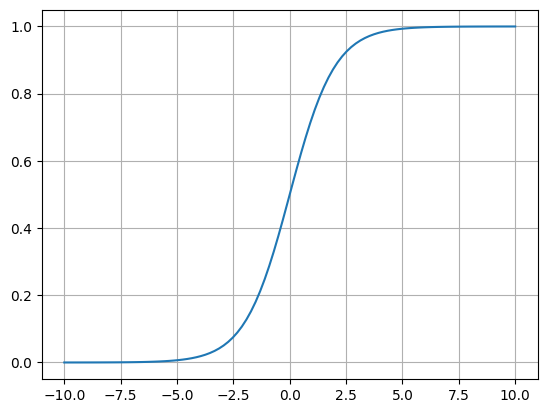

In [ ]:

def logistic(a):
  return 1. / (1.+torch.exp(-a))

def plot_function(f):
    x = torch.linspace(-10,10,100)
    y = f(x)

    return plt.plot(x,y)

plt.figure()
plot_function(logistic)
plt.grid(True)
plt.show()


As we can see, the logistic function has a minimum value of 0 and a maximum value of 1, which is perfect for estimating probabilities.

The logistic function has a nice derivative, which will come in handy later:



\begin{align}
    \frac{d \sigma}{d a} &= \frac{d}{d a} (1 + e^{-a})^{-1} \\
    &= - (1 + e^{-a})^{-2} * -e^{-a} & \text{ (chain rule)}\\
    &=\frac{e^{-a}}{(1+e^{-a})^{-2}} &\text{ (rearrange)}\\
    &= \frac{e^{-a}}{1+e^{-a}} * \frac{1}{1+e^{-a}} & \text{ (factor denominator)}\\
    \frac{d \sigma}{d a}&=\sigma(a) * (1 - \sigma(a)) &\text{ (substitute original eq)}\\
    &
\end{align}

The logistic regression model estimates the probability that the input belongs to the positive class ($p_{+}$) as follows:

\begin{align}
    p_{+} &= p(y = 1|x) \\
    &= \sigma(-w^\top x + b) & \text{(model definition)}\\
     p_{+} &=\frac{1}{1 + e^{-w^\top x + b}} &\text{(substitute)}\\
    &
\end{align}


where $w \in R^{d}, b \in R$.
Essentially, the model is the logistic function sigma ($\sigma$) applied to a linear transformation of the input $x$ using weight vector $w$.

Then because we only have two classes and probabilities must sum to 1, we also have:

\begin{align}
    p_{-} &= p(y = 0|x)\\
    & = 1 - p_{+}&\text{(sum to 1)}\\
    & = 1 - \frac{1}{1 + e^{-w^\top x + b}}&\text{(from before)}\\
    p_{-} & = \frac{e^{-w^\top x + b}}{1 + e^{-w^\top x + b}} &\text{(simplify)}\\
    &
\end{align}

Once we have the probabilities for each class, we need to actually convert these probabilities into a prediction of the input's class.
To do so, we'll simply predict that the input belongs to the most probable class.

**(exercise)** Let's implement this model and write a function to obtain predictions given the probability of the positive class:

In [ ]:
def log_reg(x, w, b):
    """This function computes logistic unit p+
    :param x: input x with n_dim features
    :param w: weght vector
    :param b: bias term
    """
    a= torch.matmul(x,w)+b
    logit = logistic(a)
    return logit


def predict(prob_pos):
    """This function returns 1 if p+>=0.5, and 0 otherwise.
    :param prob_pos: p+ modeled probability of positive example
    """
    return (prob_pos>=0.5).int()

## Training

Like with the linear regression model we used for regression, we also need to **optimize** this model by finding the "best" weights $w$. Again, "best" is defined with respect to an objective function, and for logistic regression we'll use the following objective function $L$:
$$$$
\begin{align}
    L(x, y, w) &= -(y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+})) \\
    &= - (y \cdot \log \big(\frac{1}{1 + e^{-w^\top x + b}}\big) + (1 - y) \cdot \log \big(1 - \frac{1}{1 + e^{-w^\top x + b}}\big))
\end{align}
$$$$
Unlike with linear regression, we can't get a closed form solution (i.e. a formula) for the optimal value of the weights. Instead, will use the gradient of the input function. The gradient is an extension of the concept of a derivative into many dimensions. Where a derivative is a single valued function, a gradient will have as many dimensions as the function on which it is defined.


# [Demonstration of Gradients](https://www.desmos.com/3d/j0cer6fkkg)




We rely on the fact that the gradient points opposite the direction of greatest increase. If we repeatedly take "steps" along the gradient (i.e. update the value of $w$ according to its gradient) and recompute its value after each step, we will eventually and provably reach the optimal value of the weights. This method of optimizing is known as **gradient descent**. Consider the pictorial representations below:


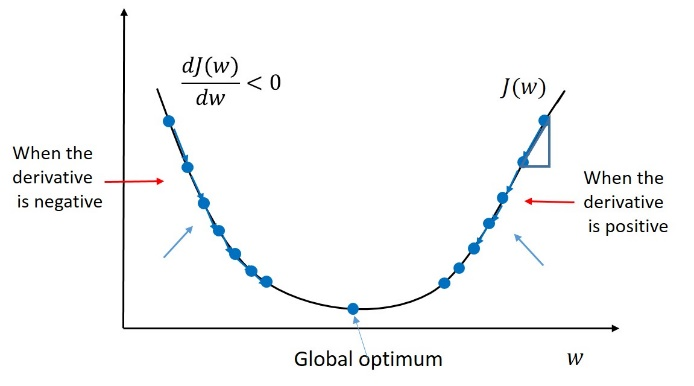
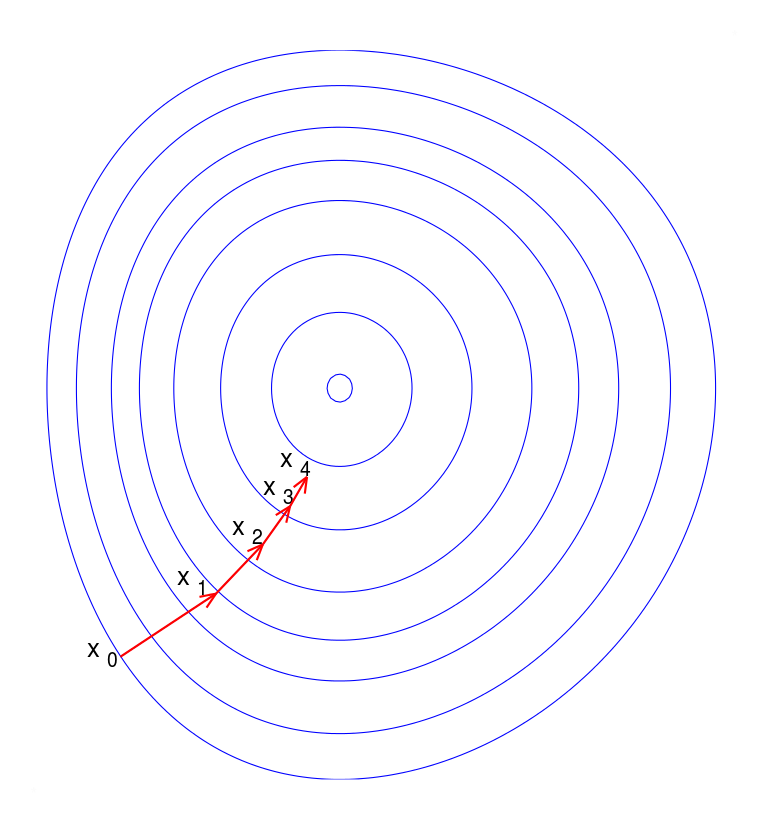






To optimize this function, we want to solve for $w$ when the gradient is equal to zero, so let's start by computing the gradient of the loss (L) with respect to the weights. In order to do this, we first need to compute the gradient of the loss with respect to the probabilty of positive prediction($p_+$), and then the use chain rule to get our desired results:
$$\nabla_w L = \nabla_w p_+ * \nabla_{p_+} L \text{ (chain rule)}$$
We can compute updates to $b$ similarly as:
$$\nabla_b L = \nabla_b p_+ * \nabla_{p_+} L\text{ (chain rule)}$$

$$$$
\begin{align}
    \nabla_{p_+} L &=\nabla_{p_+}(-y \cdot \log(p_{+}) - (1 - y) \cdot \log(1 - p_{+})) & \text{(substitute L for its definition)}\\
    &= -\big( \frac{y}{p_+} - \frac{1-y}{1 - p_+} \big)& \text{ (take derivative)}\\
    &= - \left( \frac{y(1 - p_+) - (1-y)p_+}{p_+ (1 - p_+)} \right)& \text{ (rearrange)}\\
    &= -\frac{1}{p_+ (1 - p_+)} (y - p_+)& \text{ (factor)}\\
    \nabla_w p_+ &= \nabla_w \sigma(-wx + b)& \text{ (substitute p+ for its definition)}\\
    & = -x \sigma(-wx + b) (1 - \sigma(-wx + b)) & \text{ (take derivative as in last section)}\\
    \nabla_b p_+ &= \nabla_b \sigma(-wx + b)\\
    &= \sigma(- wx + b) (1 - \sigma(-wx + b))\\
\end{align}
$$$$
Putting it all together:
$$$$
\begin{align}
    \nabla_w L &= \nabla_{p_+} L * \nabla_w p_+\\
    &= -\frac{1}{p_+ (1 - p_+)} (y - p_+) * -x \sigma(- wx+b) (1 - \sigma(-wx+b))& \text{ (substitute L and p+ for definitions)}\\
    &= -\frac{\sigma(- wx+b)(1 - \sigma(-wx+b))}{\sigma(-wx+b) (1 - \sigma(-wx+b))} (y - \sigma(-wx+b)) * -x & \text{ (rearrange)}\\
    &=  (y - \sigma(-wx+b))x& \text{ (simplify)}\\
    \nabla_b L &= \nabla_{p_+} L * \nabla_b p_+ \\
    &= -(y - \sigma(-wx+b)) & \text{ (similar as above)}
\end{align}
$$$$
**(exercise)** Let's implement this objective function and its gradient:

In [ ]:
EPS = 1e-5

def objective_fn(x, y, w, b):
    """This function computes the distance between targets and predicions.
    :param x: input x with n_dim features
    :param x: correct output according to data
    :param w: weight vector
    :param b: bias term
    """
    logits = log_reg(x,w,b)
    labels = y
    loss = -(labels*torch.log(logits+EPS)+(1-y)*torch.log(1-logits+EPS))
    return loss

def grad_objective_fn(x, y, w, b):
    """This function computes 2 gradients of the objective function, one with respect to w and one with respect to b.
    :param x: input x with n_dim features
    :param x: correct output according to data
    :param w: weight vector
    :param b: bias term
    """
    dw=torch.matmul((log_reg(x,w,b)-y),x)
    db=torch.sum(log_reg(x,w,b)-y)
    return dw,db

**(exercise)** Let's fill in the pseudocode for this training algorithm. To know that our implementation is correct, we'll evaluate and keep track of the value of the objective function at each step. If the objective function value decreases, we'll know we've probably implemented the algorithm correctly.

In [ ]:
# Training loop
n_dim = 2
n_iter = 10000
eta = 0.0001   # Learning rate / step size
w = 0.01 * torch.randn(n_dim) # initial value
b = 0.0

cost_log = []

for ni in tqdm(range(n_iter)):
    # TODO: compute the gradients on the training data using the current parameters
    dw,db = grad_objective_fn(X_train,y_train, w,b)

    # TODO: update the parameters using learning rate * the gradient
    w -= eta*dw
    b -=eta*db

    # compute the objective (to see how we're doing) and store it in cost_log
    cost = torch.mean(objective_fn(X_train,y_train, w,b))
    cost_log.append(cost)


100%|██████████| 10000/10000 [00:07<00:00, 1334.31it/s]


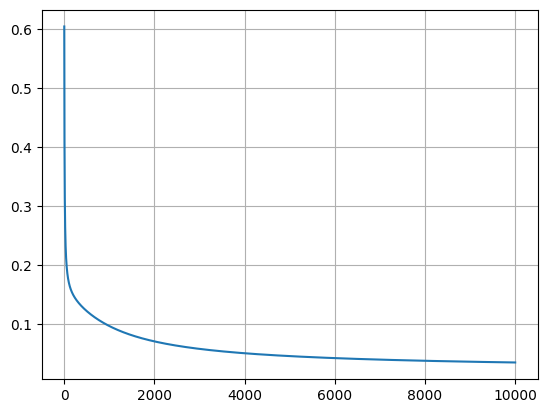

In [ ]:
# Plot cost over training iterations
plt.figure()
plt.plot(cost_log)
plt.grid(True)
plt.show()

## Evaluation



Now that we've trained the model, let's see how good are model is by evaluating it on the test set. Note that we typically don't care about the actual value of the objective function $L$ we achieve; the objective function is a proxy for another objective we want but that is harder to optimize. In this case, we care about the **accuracy** of the model, or how often its predictions are accurate.

**(exercise)** Implement accuracy, and evaluate the accuracy and loss of the model on the test set.


In [ ]:
train_preds = predict(log_reg(X_train, w, b))
test_preds = predict(log_reg(X_test, w, b))

# accuracy code
def accuracy(targs, preds):
  return torch.mean(torch.eq(targs,preds).float())

# TODO: print accuracy on training data
print(accuracy(y_train, train_preds))
# TODO: print accuracy on test data
print(accuracy(y_test,test_preds))
# TODO: print average loss on training data
print(torch.mean(objective_fn(X_train,y_train,w,b)))
    # TODO: print average loss on test data
print(torch.mean(objective_fn(X_test,y_test,w,b)))


tensor(0.9906)
tensor(0.9925)
tensor(0.0354)
tensor(0.0368)


## Models in PyTorch

Manually computing and implementing gradients for every model we want to use is tedious, and can quickly become overwhelming as we move on to more complex models. Modern code frameworks for machine learning like Pytorch can automatically compute gradients, as well as provide other conveniences.

PyTorch provides a submodule for implementing and building machine learning models called `torch.nn` (`nn` for neural networks). `nn` implements many common mathematical transformations as functions that can be chained together to build machine learning modules. Let's go over an example of creating and using logistic regression in PyTorch.

In [ ]:
import torch.nn as nn

class BinaryLogisticRegression(nn.Module):

  def __init__(self, input_dim):
    super(BinaryLogisticRegression, self).__init__()
    self.linear = nn.Linear(input_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    outputs = self.sigmoid(self.linear(input)) # includes the bias term
    return outputs

model = BinaryLogisticRegression(n_dim) # instantiate model
print(f"Model: {model}")
print(f"Linear weights:\n {model.linear.weight}")
print(f"Linear bias:\n {model.linear.bias}")
print()
print(f"Dummy model outputs: {model(torch.rand(2))}")


Model: BinaryLogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Linear weights:
 Parameter containing:
tensor([[0.0827, 0.2940]], requires_grad=True)
Linear bias:
 Parameter containing:
tensor([0.0072], requires_grad=True)

Dummy model outputs: tensor([0.5346], grad_fn=<SigmoidBackward0>)


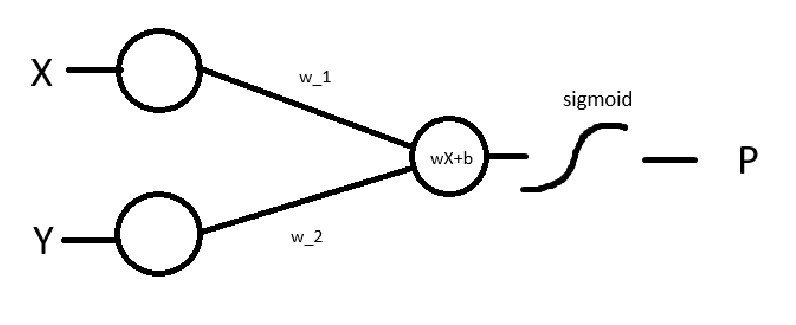

## A Gentle Introduction To `torch.autograd`

`torch.autograd` is PyTorch’s automatic differentiation engine that powers neural network training. In this section, you will get a conceptual understanding of how autograd helps a neural network train.

### Background

Neural networks (NNs) are a collection of nested functions that are executed on some input data. These functions are defined by parameters (consisting of weights and biases), which in PyTorch are stored in tensors.

Training a NN happens in two steps:

**Forward Propagation:** In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

**Backward Propagation:** In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent. For a more detailed walkthrough of backprop, [check out this video from 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

### Differentiation in Autograd

In [ ]:
import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor Q from a and b.

$Q=3a^{3} - b^{2}$

In [ ]:
Q = 3*a**3 - b**2

Let’s assume a and b to be parameters of an NN, and Q to be the error. In NN training, we want gradients of the error w.r.t. parameters, i.e.

$\frac{\partial Q}{\partial a} = 9a^{2}$

$\frac{\partial Q}{\partial b} = -2b$

When we call .backward() on Q, autograd calculates these gradients and stores them in the respective tensors’ .grad attribute.

We need to explicitly pass a gradient argument in Q.backward() because it is a vector. gradient is a tensor of the same shape as Q, and it represents the gradient of Q w.r.t. itself, i.e.

$\frac{\partial Q}{\partial Q} = 1$

Equivalently, we can also aggregate Q into a scalar and call backward implicitly, like Q.sum().backward().



In [ ]:
external_grad = torch.tensor([1., 1.])
Q.backward(gradient=external_grad)

Gradients are now deposited in a.grad and b.grad

In [ ]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


Because our model is essentially a function of its weights and inputs, we can find the gradients of the output of our model with respect to these variables in a similar way automatically from pytorch:

In [ ]:
loss_fn = nn.BCELoss()
output = model(X_train).float()
loss = loss_fn(output.squeeze(), y_train)
loss.backward()

for param in model.parameters():
  print(param.grad)

tensor([[-1.0572,  1.4914]])
tensor([0.0635])


Now, let's use the a pytorch optimizer already written for us to update the weights and biases for us in a training loop. The lr parameter is a learning rate that adjusts how much to update the parameters on each training step. If this number is too small, it may take very long to reach a good model. If it is too large, the function may have trouble converging on the minimum, instead jumping back and forth around it.

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=0.001)
for _ in tqdm(range(10000)):
  # zero out gradients before each iter
  optim.zero_grad()

  #get current predictions and the loss
  output = model(X_train).float()
  loss = loss_fn(output.squeeze(), y_train)

  #calculate gradients for each parameter
  loss.backward()

  #update each parameter according to calculated gradients
  optim.step()

print("\n Accuracy: " + str(accuracy(y_test, predict(model(X_test)).squeeze())))

100%|██████████| 10000/10000 [00:07<00:00, 1318.43it/s]


 Accuracy: tensor(0.9450)


## The XOR Problem

Let's say we want a model to determine if the multiplication of two input parameters will be positive or negative.

If $x_1$ and $x_2$ are both positive or both negative, we should put them in the positive category. If they are different, we should classify them as negative. Essentially, we are performing an xor on the values of the inputs:
$$$$
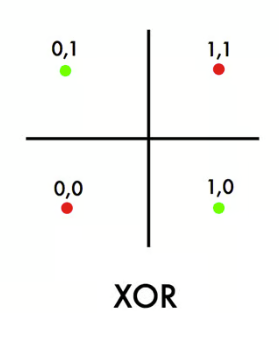
$$$$
Let's try generating some data and apply the previous methods to train a model to do this classification problem.

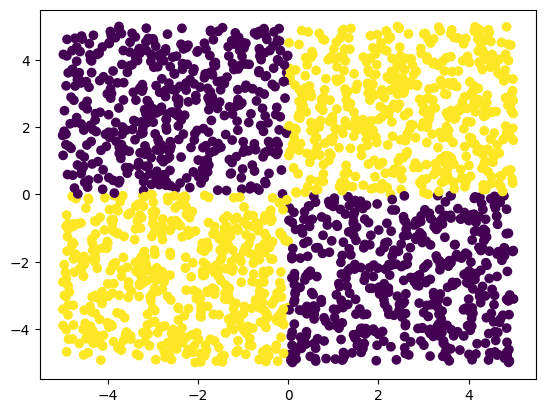

In [ ]:
import random
random.seed(random_seed)

X = torch.tensor([[random.random()*10-5,random.random()*10-5] for _ in range(2000)]).float()
y = torch.tensor([1 if X[i][0]*X[i][1]>0 else 0 for i in range(2000)]).float()

plot.figure()
plot.scatter(X[:,0], X[:,1], c=y)
plot.show()

Next, let's reuse the structure of the model we just used, and train it to do this classification task. Should be easy.



100%|██████████| 1000/1000 [00:00<00:00, 1335.56it/s]



 Accuracy: tensor(0.4375)


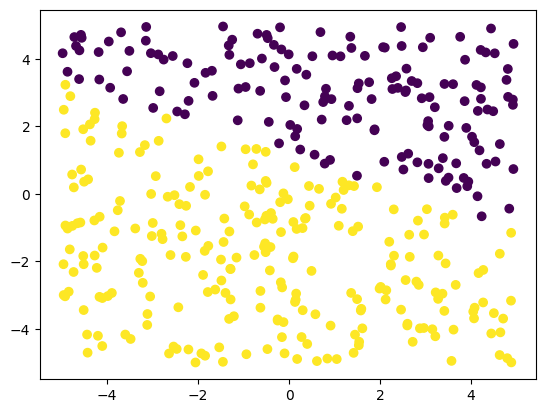

In [ ]:
#split into train and test (you've seen this)
n_exs = len(X)
n_train = int(n_exs * .8)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

#run training loop (you've seen this)
optim = torch.optim.SGD(model.parameters(), lr=0.001)
for _ in tqdm(range(1000)):
  optim.zero_grad()
  output = model(X_train).float()
  loss = loss_fn(output.squeeze(), y_train)
  loss.backward()
  optim.step()

#print accuracy stats
print("\n Accuracy: " + str(accuracy(y_test, predict(model(X_test)).squeeze())))

#plot the predictions of our model
plot.figure()
plot.scatter(X_test[:,0], X_test[:,1], c=predict(model(X_test)))
plot.show()


Oh no! Our model is barely better than guessing! This is because our current model is linear. A *linear model* is a model that assumes that there is a linear decision boundary between classifications. In 2 dimensions, that boundary is a line. in 3, it's a plane. In n dimensions, it's an n-1 dimensional uncurving space. Because we have only used linear layers before our sigmoid decision making node, we have a linear model. Just by looking at our problem, we can clearly see that it is not solvable with a single linear decision boundary. This is where *activation functions* come in. If we apply non-linear functions between 2 linear layers, then the resultant model will no longer be linear. Lets use the sigmoid function again as our nonlinearity, and try again, this time defining a new architecture. We shall call it:
##The Multi Layer Perceptron

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.linear = nn.Linear(input_dim, 10)
        self.hidden = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        return self.sigmoid(self.hidden(self.sigmoid(self.linear(x))))

xor_model = MultiLayerPerceptron(n_dim) # instantiate model

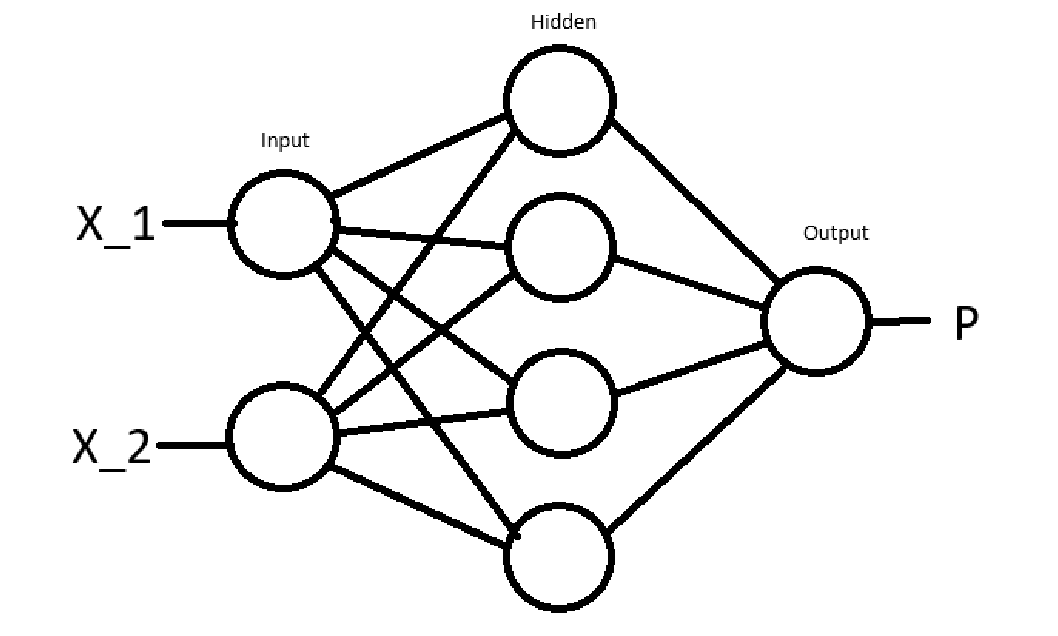

Our new model has 2 layers of nodes called *perceptrons* or *neurons* (hence the term neural network). Each node takes its input, adds it to a learnable bias term, multiplies it by the weight associated with edges coming out of the node, and passes along this result to the next neuron. In the above network, we have a layer of 2 input nodes connected to a layer of 4 hidden nodes which are connected to the final output node. Additional hidden nodes and additional layers allow the decision boundary to be more complex, at the expense of longer training times and training complexity.

Each layer can neatly summarized by the equation:

$$\sigma(Wx+b)$$

Where $\sigma$ is the sigmoid activation function, W is a matrix containing the weights between the neurons, x is a vector representing the input to that layer, and b is the bias vector.

Let's train the model now.

In [ ]:
#run training loop (you've seen this)
optim = torch.optim.SGD(xor_model.parameters(), lr=1)
for _ in tqdm(range(1000)):
  #TODO: use optim to train our model
  optim.zero_grad()
  output = xor_model(X_train).float()
  loss= loss_fn(output.squeeze(),y_train)
  loss.backward()
  optim.step()

print("\n Accuracy: " + str(accuracy(y_test, predict(xor_model(X_test)).squeeze())))

100%|██████████| 1000/1000 [00:00<00:00, 1098.18it/s]


 Accuracy: tensor(0.9950)


Let's take a look at those decision boundaries now:

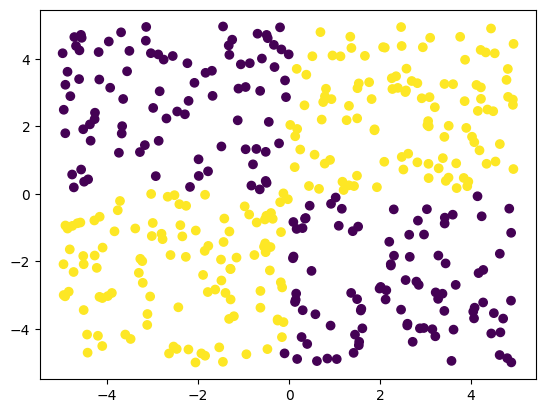

In [ ]:
plot.figure()
plot.scatter(X_test[:,0], X_test[:,1], c=predict(xor_model(X_test)))
plot.show()

##Design a model
Much better. Now lets work on another problem. Design a model on your own that solves this problem. See if you can achieve an accuracy >90%. We have written some template code and the training loop for you:

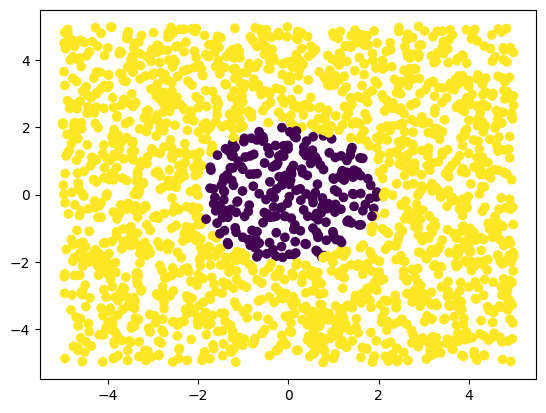

In [ ]:
X = torch.tensor([[random.random()*10-5,random.random()*10-5] for _ in range(2000)]).float()
y = torch.tensor([1 if X[i][0]*X[i][0]+X[i][1]*X[i][1]>4 else 0 for i in range(2000)]).float()
n_exs = len(X)
n_train = int(n_exs * .8)
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

plot.figure()
plot.scatter(X[:,0], X[:,1], c=y)
plot.show()

In [ ]:
class YourArchitecture(nn.Module):
    def __init__(self, input_dim):
        super(YourArchitecture, self).__init__()
        self.linear = nn.Linear(input_dim, 10)
        self.hidden = nn.Linear(10, 10)
        self.hidden2 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        return self.sigmoid(self.hidden2(self.sigmoid(self.hidden(self.sigmoid(self.linear(x))))))

circle_model = YourArchitecture(n_dim)
#run training loop (you've seen this)
optim = torch.optim.SGD(circle_model.parameters(), lr=1)
for _ in tqdm(range(1000)):
    optim.zero_grad()
    output = circle_model(X_train).float()
    loss = loss_fn(output.squeeze(), y_train)
    loss.backward()
    optim.step()

print("\n Accuracy: " + str(accuracy(y_test, predict(circle_model(X_test)).squeeze())))

100%|██████████| 1000/1000 [00:01<00:00, 889.75it/s]


 Accuracy: tensor(0.9825)


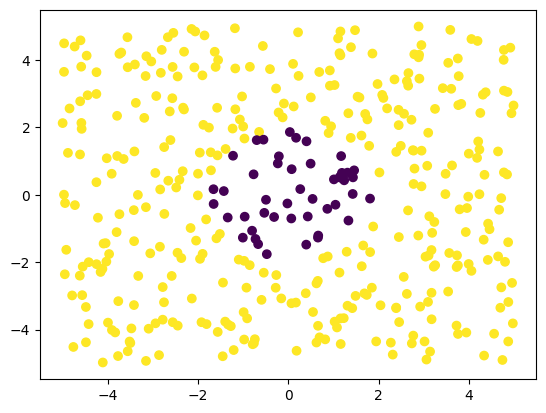

In [ ]:
plot.figure()
plot.scatter(X_test[:,0], X_test[:,1], c=predict(circle_model(X_test)))
plot.show()

Congrats! You have finished the classification lab.